 # generate movies

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
w = cluster.scale(30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.37:36216 Dashboard: http://10.135.36.37:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## load grid and data

In [25]:
#v, vmin, vmax = 'Eta', -2., 2.
v, vmin, vmax = 'SSU', -1., 1.
#v, vmin, vmax = 'SST', 3., 30.

In [26]:
grd = load_grd()
if v in ['Eta','SST','SSS']:
    ds = load_data(v)
elif v in ['SSU','SSV']:
    dsu = load_data('SSU').rename({'i_g':'i'})
    dsv = load_data('SSV').rename({'j_g':'j'})
    ds = xr.merge([dsu, dsv])      
ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
       .drop(['Depth','rA', 'hFacC']))

# rotate if necessary
if v in ['SSU','SSV']:
    ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
    ds = ds.drop(['SSU','SSV'])
    if v is 'SSU': v = 'SSU_geo' 
    if v is 'SSV': v = 'SSV_geo' 
print(ds)
print(v)

print('\n data set (all faces): %.1f GB' %(ds.nbytes / 1e9))
print('\n variable size (all faces): %.1f GB' %(ds[v].nbytes / 1e9))
print('\n data size (1 time): %.1f GB' %(ds[v].isel(time=0).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<shape=(8785,), chunksize=(1,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
Data variables:
    SSU_geo  (time, face, j, i) float32 dask.array<shape=(8785, 13, 4320, 43

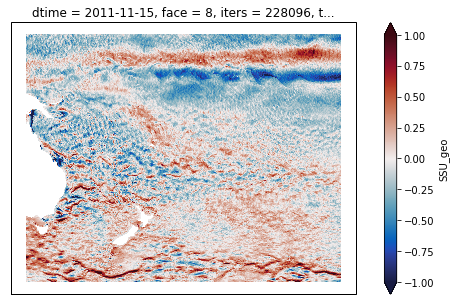

In [29]:
# plot one figure to check lon/lat treatment
dv = ds[v].isel(face=8, time=0)
# for faces that cross the date longitude
dv = dv.assign_coords(XC=((dv.XC+180.)% 360))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#cmap = cm.thermal
cmap = cm.balance
#cmap = plt.get_cmap('RdGy_r')
dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=3., vmax=30., cmap=cmap)
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), cmap=cmap)

---

# make movie

In [66]:
_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance,
           'SSU_geo': cm.balance, 'SSV_geo': cm.balance,
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}

_region_params = {'atlantic': {'faces':[0,1,2,6,10,11,12],'extent':[-110,25,-70,70], 'projection': ccrs.Mollweide()}, 
                  'south-atlantic':{'faces':[1,11,0,12],'extent':[-50,20,-60,5],
                                    'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,
                                                                                 central_latitude=-30)},
                  'south-pacific':{'faces':[8,9,11,12],'extent':[170,-80, -50, 5.],
                                    'projection': ccrs.Stereographic(central_longitude=-130.,
                                                                                 central_latitude=3.0)}}

[170, -80, -50, 5.0]


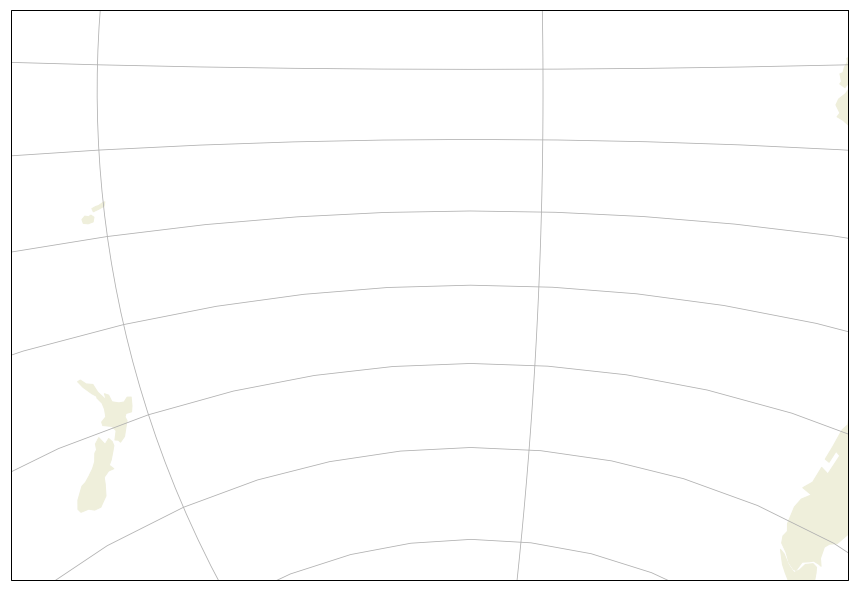

In [67]:

def plot_pretty_fake(figsize=(15,15), projection=None, extent=None, region=None):

        if region is not None:
            _extent = _region_params[region]['extent']
            _projection = _region_params[region]['projection']
        else:
            _projection = ccrs.Robinson()
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        print(_extent)
        ax.set_extent(_extent)
        gl = ax.gridlines()
        ax.add_feature(cfeature.LAND)
        return fig, ax
    

#fig, ax = plot_pretty_fake(region='south-atlantic')
fig, ax = plot_pretty_fake(region='south-pacific')

In [68]:
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name] 
    else:
        return plt.get_cmap('magma')   

#                  'south-atlantic':{'faces':[0,1,11,12],'extent':[-100,25,-70,5]},}

def plot_pretty(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(15,15), cmap=None,
                ignore_face=[], projection=None, extent=None, region=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        if 'face' not in v.dims:
            v = v.expand_dims('face')
        if region is not None:
            _extent = _region_params[region]['extent']
            gen = (face for face in _region_params[region]['faces'] 
                   if face not in ignore_face)
            _projection = _region_params[region]['projection']
        else:
            gen = (face for face in v.face.values if face not in ignore_face)
            _projection = ccrs.Robinson()
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        ax.set_extent(_extent)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>0) & (vplt.XC<179.)).plot.pcolormesh(ax=ax,
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap)
                im = vplt.where(vplt.XC<0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap)
        fig.colorbar(im)
        # grid lines:
        gl = ax.gridlines()
        #ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
        #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        #lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #lat_formatter = LatitudeFormatter()
        #ax.xaxis.set_major_formatter(lon_formatter)
        #ax.yaxis.set_major_formatter(lat_formatter)        
        # only with platecarre
        #if projection is 'PlateCarre':
        #    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
        #                    alpha=0.5, linestyle='--')
        #    gl.xlabels_top = False
        
        # coastlines and land:
        #if coast_resolution is not None:
        #    ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)
        #
        if title is not None:
            ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax

In [16]:
# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

#face = 1
#lds = ds.isel(face=face)
lds = ds

def genfig(ds, v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    
    # !! passing the variable does not work
    dv = ds[v]

    #time = pd.to_datetime(str(eta['time'].values))
    #time = dv['time'].values/86400.
    time = pd.to_datetime(dv['dtime'].values)
    #figname = figdir+'%s_f%d_t%05d' %(v, face, i)+'.png'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


Process all times

In [ ]:
I = range(len(ds['time']))
I = range(10)
values = [delayed(genfig)(lds.isel(time=i), v, i) for i in I]

In [ ]:
futures = client.compute(values)
%time results = client.gather(futures)

Process a selection of times

In [17]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    #lds = ds.isel(time=slice(I[0],I[-1]+1))
    #values = [delayed(genfig)(lds.isel(time=i), v, I[i]) for i in range(len(I))]
    values = [delayed(genfig)(ds.isel(time=i), v, i, overwrite=False) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 14.8 s, sys: 1.08 s, total: 15.9 s
Wall time: 1min 56s
6020 - 6039
CPU times: user 14.9 s, sys: 1.05 s, total: 16 s
Wall time: 1min 59s
6040 - 6059
CPU times: user 14 s, sys: 1.03 s, total: 15 s
Wall time: 1min 50s
6060 - 6079
CPU times: user 14.6 s, sys: 952 ms, total: 15.6 s
Wall time: 1min 55s
6080 - 6099
CPU times: user 15 s, sys: 1.03 s, total: 16 s
Wall time: 1min 56s
6100 - 6119
CPU times: user 13.3 s, sys: 1.01 s, total: 14.4 s
Wall time: 1min 46s
6120 - 6139
CPU times: user 14.6 s, sys: 961 ms, total: 15.5 s
Wall time: 1min 56s
6140 - 6159
CPU times: user 15.2 s, sys: 1.01 s, total: 16.2 s
Wall time: 1min 59s
6160 - 6179
CPU times: user 14.5 s, sys: 950 ms, total: 15.4 s
Wall time: 1min 52s
6180 - 6199
CPU times: user 14.9 s, sys: 1.05 s, total: 16 s
Wall time: 1min 54s
6200 - 6219
CPU times: user 13.9 s, sys: 879 ms, total: 14.8 s
Wall time: 1min 43s
6220 - 6239
CPU times: user 14.7 s, sys: 984 ms, total: 15.7 s
Wall time: 1min

distributed.scheduler - ERROR - '8773471'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773471'


CPU times: user 18.4 s, sys: 1.28 s, total: 19.7 s
Wall time: 2min 27s
6560 - 6579
CPU times: user 13.6 s, sys: 909 ms, total: 14.5 s
Wall time: 1min 44s
6580 - 6599
CPU times: user 15.9 s, sys: 1.12 s, total: 17 s
Wall time: 2min 2s
6600 - 6619
CPU times: user 14.4 s, sys: 931 ms, total: 15.3 s
Wall time: 1min 50s
6620 - 6639
CPU times: user 14.6 s, sys: 983 ms, total: 15.5 s
Wall time: 1min 59s
6640 - 6659
CPU times: user 14.2 s, sys: 1e+03 ms, total: 15.2 s
Wall time: 1min 52s
6660 - 6679
CPU times: user 15.9 s, sys: 1.14 s, total: 17.1 s
Wall time: 2min 1s
6680 - 6699
CPU times: user 14.8 s, sys: 976 ms, total: 15.8 s
Wall time: 1min 55s
6700 - 6719
CPU times: user 15.1 s, sys: 974 ms, total: 16.1 s
Wall time: 1min 57s
6720 - 6739
CPU times: user 14 s, sys: 910 ms, total: 14.9 s
Wall time: 1min 57s
6740 - 6759


distributed.scheduler - ERROR - '8773476'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773476'


CPU times: user 17.5 s, sys: 1.16 s, total: 18.7 s
Wall time: 2min 24s
6760 - 6779


distributed.scheduler - ERROR - '8773491'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773491'


CPU times: user 20.3 s, sys: 1.34 s, total: 21.7 s
Wall time: 2min 54s
6780 - 6799
CPU times: user 14 s, sys: 906 ms, total: 14.9 s
Wall time: 1min 54s
6800 - 6819
CPU times: user 13.6 s, sys: 870 ms, total: 14.5 s
Wall time: 1min 43s
6820 - 6839


distributed.scheduler - ERROR - '8773473'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773473'


CPU times: user 16.3 s, sys: 1.15 s, total: 17.5 s
Wall time: 2min 20s
6840 - 6859
CPU times: user 14.7 s, sys: 935 ms, total: 15.6 s
Wall time: 1min 55s
6860 - 6879
CPU times: user 14 s, sys: 903 ms, total: 14.9 s
Wall time: 1min 54s
6880 - 6899
CPU times: user 14.2 s, sys: 894 ms, total: 15.1 s
Wall time: 1min 53s
6900 - 6919
CPU times: user 13.7 s, sys: 864 ms, total: 14.6 s
Wall time: 1min 44s
6920 - 6939
CPU times: user 12.9 s, sys: 826 ms, total: 13.7 s
Wall time: 1min 44s
6940 - 6959
CPU times: user 14 s, sys: 888 ms, total: 14.8 s
Wall time: 1min 50s
6960 - 6979


distributed.scheduler - ERROR - '8773497'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773497'
distributed.scheduler - ERROR - '8773482'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773482'


CPU times: user 19.5 s, sys: 1.26 s, total: 20.8 s
Wall time: 2min 38s
6980 - 6999
CPU times: user 14.4 s, sys: 938 ms, total: 15.3 s
Wall time: 1min 54s
7000 - 7019
CPU times: user 13.9 s, sys: 898 ms, total: 14.8 s
Wall time: 1min 49s
7020 - 7039
CPU times: user 12.7 s, sys: 780 ms, total: 13.5 s
Wall time: 1min 43s
7040 - 7059
CPU times: user 13 s, sys: 853 ms, total: 13.9 s
Wall time: 1min 37s
7060 - 7079
CPU times: user 14.5 s, sys: 985 ms, total: 15.5 s
Wall time: 1min 52s
7080 - 7099
CPU times: user 14.5 s, sys: 967 ms, total: 15.5 s
Wall time: 1min 49s
7100 - 7119
CPU times: user 14.2 s, sys: 918 ms, total: 15.1 s
Wall time: 1min 53s
7120 - 7139
CPU times: user 14.1 s, sys: 952 ms, total: 15 s
Wall time: 1min 50s
7140 - 7159
CPU times: user 14.6 s, sys: 967 ms, total: 15.5 s
Wall time: 1min 55s
7160 - 7179
CPU times: user 14.7 s, sys: 970 ms, total: 15.7 s
Wall time: 1min 57s
7180 - 7199


distributed.scheduler - ERROR - '8773474'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773474'


CPU times: user 17.4 s, sys: 1.15 s, total: 18.6 s
Wall time: 2min 21s
7200 - 7219
CPU times: user 15 s, sys: 957 ms, total: 15.9 s
Wall time: 1min 57s
7220 - 7239


distributed.scheduler - ERROR - '8773479'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773479'


CPU times: user 14.7 s, sys: 974 ms, total: 15.7 s
Wall time: 1min 57s
7240 - 7259


distributed.scheduler - ERROR - '8773488'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773488'
distributed.scheduler - ERROR - '8773485'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773485'


CPU times: user 15.9 s, sys: 1.03 s, total: 16.9 s
Wall time: 2min 3s
7260 - 7279


distributed.scheduler - ERROR - '8773500'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773500'


CPU times: user 15.2 s, sys: 1.05 s, total: 16.3 s
Wall time: 1min 59s
7280 - 7299
CPU times: user 14.4 s, sys: 961 ms, total: 15.4 s
Wall time: 1min 55s
7300 - 7319
CPU times: user 14.3 s, sys: 876 ms, total: 15.2 s
Wall time: 1min 53s
7320 - 7339


distributed.scheduler - ERROR - '8773471'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1712, in remove_worker
    plugin.remove_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 74, in remove_worker
    del self.running_jobs[job_id][name]
KeyError: '8773471'
distributed.scheduler - ERROR - '8773471'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773471'


CPU times: user 17.1 s, sys: 1.13 s, total: 18.3 s
Wall time: 2min 25s
7340 - 7359


distributed.scheduler - ERROR - '8773496'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773496'


CPU times: user 19.1 s, sys: 1.33 s, total: 20.4 s
Wall time: 2min 37s
7360 - 7379


distributed.scheduler - ERROR - '8773476'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1712, in remove_worker
    plugin.remove_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 74, in remove_worker
    del self.running_jobs[job_id][name]
KeyError: '8773476'
distributed.scheduler - ERROR - '8773476'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773476'


CPU times: user 15.2 s, sys: 998 ms, total: 16.2 s
Wall time: 2min
7380 - 7399
CPU times: user 14.6 s, sys: 965 ms, total: 15.6 s
Wall time: 1min 57s
7400 - 7419
CPU times: user 15.1 s, sys: 967 ms, total: 16 s
Wall time: 2min
7420 - 7439
CPU times: user 14.4 s, sys: 945 ms, total: 15.4 s
Wall time: 1min 56s
7440 - 7459
CPU times: user 15.1 s, sys: 1.02 s, total: 16.1 s
Wall time: 1min 59s
7460 - 7479
CPU times: user 14.8 s, sys: 977 ms, total: 15.8 s
Wall time: 2min
7480 - 7499
CPU times: user 14.8 s, sys: 913 ms, total: 15.7 s
Wall time: 1min 59s
7500 - 7519


distributed.scheduler - ERROR - '8773477'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773477'


CPU times: user 17.2 s, sys: 1.2 s, total: 18.4 s
Wall time: 2min 17s
7520 - 7539
CPU times: user 14.1 s, sys: 860 ms, total: 15 s
Wall time: 1min 58s
7540 - 7559
CPU times: user 15 s, sys: 1.01 s, total: 16 s
Wall time: 1min 57s
7560 - 7579
CPU times: user 13.3 s, sys: 873 ms, total: 14.2 s
Wall time: 1min 38s
7580 - 7599
CPU times: user 14.4 s, sys: 969 ms, total: 15.3 s
Wall time: 1min 55s
7600 - 7619


distributed.scheduler - ERROR - '8773490'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773490'


CPU times: user 16 s, sys: 991 ms, total: 17 s
Wall time: 2min 6s
7620 - 7639
CPU times: user 12.9 s, sys: 846 ms, total: 13.8 s
Wall time: 1min 47s
7640 - 7659
CPU times: user 14.2 s, sys: 941 ms, total: 15.1 s
Wall time: 1min 52s
7660 - 7679
CPU times: user 14.6 s, sys: 974 ms, total: 15.6 s
Wall time: 1min 56s
7680 - 7699
CPU times: user 13.6 s, sys: 877 ms, total: 14.5 s
Wall time: 1min 42s
7700 - 7719
CPU times: user 14.5 s, sys: 955 ms, total: 15.4 s
Wall time: 1min 56s
7720 - 7739
CPU times: user 13.2 s, sys: 833 ms, total: 14 s
Wall time: 1min 44s
7740 - 7759


distributed.scheduler - ERROR - '8773481'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773481'


CPU times: user 16 s, sys: 1.09 s, total: 17.1 s
Wall time: 2min 5s
7760 - 7779
CPU times: user 14.6 s, sys: 866 ms, total: 15.5 s
Wall time: 1min 57s
7780 - 7799
CPU times: user 15.4 s, sys: 1.05 s, total: 16.5 s
Wall time: 2min 1s
7800 - 7819


distributed.scheduler - ERROR - '8773487'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773487'


CPU times: user 15.3 s, sys: 1.02 s, total: 16.4 s
Wall time: 1min 58s
7820 - 7839
CPU times: user 13.6 s, sys: 933 ms, total: 14.6 s
Wall time: 1min 44s
7840 - 7859


distributed.scheduler - ERROR - '8773483'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773483'
distributed.scheduler - ERROR - '8773480'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773480'


CPU times: user 16 s, sys: 1.05 s, total: 17.1 s
Wall time: 2min 8s
7860 - 7879


distributed.scheduler - ERROR - '8773475'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773475'


CPU times: user 17.6 s, sys: 1.21 s, total: 18.8 s
Wall time: 2min 23s
7880 - 7899
CPU times: user 15 s, sys: 972 ms, total: 15.9 s
Wall time: 1min 58s
7900 - 7919
CPU times: user 14.5 s, sys: 988 ms, total: 15.4 s
Wall time: 1min 52s
7920 - 7939
CPU times: user 14.3 s, sys: 907 ms, total: 15.2 s
Wall time: 1min 56s
7940 - 7959


distributed.scheduler - ERROR - '8773491'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1712, in remove_worker
    plugin.remove_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 74, in remove_worker
    del self.running_jobs[job_id][name]
KeyError: '8773491'
distributed.scheduler - ERROR - '8773491'
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '8773491'


CPU times: user 18.1 s, sys: 1.17 s, total: 19.3 s
Wall time: 2min 27s
7960 - 7979
CPU times: user 14.4 s, sys: 965 ms, total: 15.4 s
Wall time: 1min 57s
7980 - 7999
CPU times: user 13.2 s, sys: 899 ms, total: 14.1 s
Wall time: 1min 41s


In [ ]:
cluster.close()

---

### another strategy: load data in each loop

In [10]:
# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def load_and_genfig(v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'

    if not os.path.isfile(figname) or overwrite:

        grd = load_grd()
        if v in ['Eta','SST','SSS']:
            ds = load_data(v).rename({'i_g':'i'}).isel(time=i)
        elif v in ['SSU','SSV','SSU_geo','SSV_geo']:
            dsu = load_data('SSU').rename({'i_g':'i'}).isel(time=i)
            dsv = load_data('SSV').rename({'j_g':'j'}).isel(time=i)
            ds = xr.merge([dsu, dsv])      
        ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
               .drop(['Depth','rA', 'hFacC']))

        # rotate if necessary
        if v in ['SSU','SSV','SSU_geo','SSV_geo']:
            ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
            ds = ds.drop(['SSU','SSV'])
            if v is 'SSU': v = 'SSU_geo' 
            if v is 'SSV': v = 'SSV_geo'

        dv = ds[v]    
        time = pd.to_datetime(dv['dtime'].values)
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [12]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
I = II[0]
print('%d - %d'%(I[0],I[-1]))
values = [delayed(load_and_genfig)(v, i) for i in I]    
futures = client.compute(values)
%time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 1min 9s, sys: 3.75 s, total: 1min 13s
Wall time: 2min 44s


In [11]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    values = [delayed(load_and_genfig)(v, i) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 1min 15s, sys: 4.26 s, total: 1min 20s
Wall time: 2min 45s
6020 - 6039
CPU times: user 1min 9s, sys: 3.75 s, total: 1min 13s
Wall time: 2min 37s
6040 - 6059
CPU times: user 1min 10s, sys: 4.17 s, total: 1min 14s
Wall time: 2min 44s
6060 - 6079
CPU times: user 1min 11s, sys: 4.32 s, total: 1min 16s
Wall time: 2min 44s
6080 - 6099
CPU times: user 1min 11s, sys: 4.25 s, total: 1min 15s
Wall time: 2min 38s
6100 - 6119
CPU times: user 1min 11s, sys: 4.26 s, total: 1min 15s
Wall time: 2min 43s
6120 - 6139
CPU times: user 1min 8s, sys: 4.12 s, total: 1min 12s
Wall time: 2min 40s
6140 - 6159
CPU times: user 1min 12s, sys: 4.45 s, total: 1min 16s
Wall time: 2min 47s
6160 - 6179
CPU times: user 1min 16s, sys: 4.78 s, total: 1min 21s
Wall time: 2min 49s
6180 - 6199
CPU times: user 1min 12s, sys: 4.35 s, total: 1min 17s
Wall time: 2min 47s
6200 - 6219
CPU times: user 1min 10s, sys: 4.04 s, total: 1min 14s
Wall time: 2min 40s
6220 - 6239
CPU times: u

CPU times: user 1min 13s, sys: 4.25 s, total: 1min 17s
Wall time: 2min 46s
7920 - 7939
CPU times: user 1min 14s, sys: 4.4 s, total: 1min 19s
Wall time: 2min 54s
7940 - 7959
CPU times: user 1min 14s, sys: 4.43 s, total: 1min 19s
Wall time: 2min 55s
7960 - 7979
CPU times: user 1min 13s, sys: 4.4 s, total: 1min 17s
Wall time: 2min 45s
7980 - 7999
CPU times: user 1min 11s, sys: 4.19 s, total: 1min 15s
Wall time: 2min 40s


In [12]:
cluster.close()

```
ffmpeg -f image2 -r 20 -pattern_type glob -i "./figs/*_t00*.png" -q:v 1 ./out.mp4
```

---

# individual figures

(for colormaps ...)

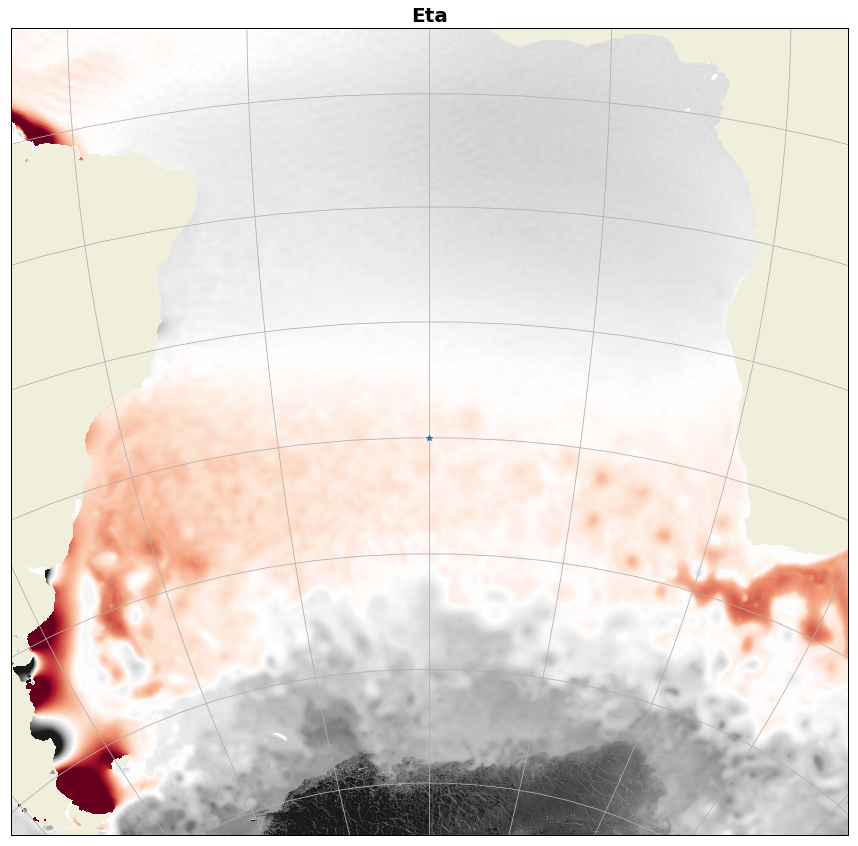

In [9]:
fig, ax = plot_pretty(ds[v].isel(time=0), vmin=-2., vmax=2., region='south-atlantic',
                      title=v, colorbar=True)
#ax.plot(-15.,-30., '*', transform=ccrs.PlateCarree())
# ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,central_latitude=-30)
# ccrs.AzimuthalEquidistant(central_longitude=-15.,central_latitude=-30)
# ccrs.Stereographic(central_longitude=-15,central_latitude=-30)
#ax.gridlines() # does not show up with transverse mercator

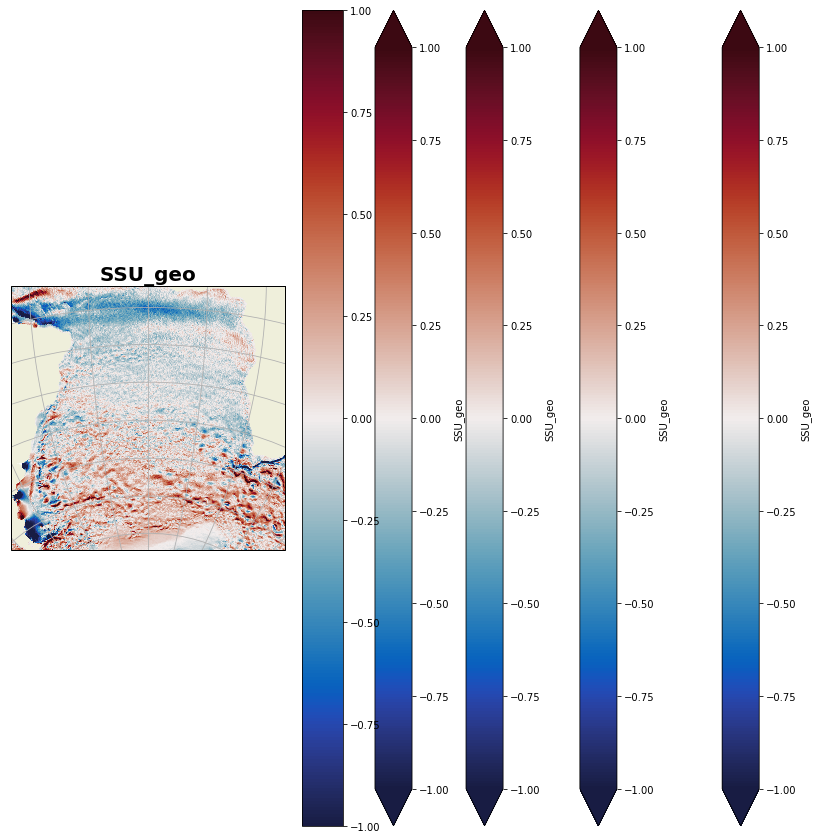

In [69]:
fig, ax = plot_pretty(ds[v].isel(time=0), vmin=vmin, vmax=vmax, region='south-atlantic',
                      title=v, colorbar=True)

In [ ]:
fig, ax = plot_pretty(ds[v].isel(time=0), vmin=-2., vmax=2., region='south-atlantic',
                      title=v, colorbar=True)

In [31]:
fig, ax = plot_pretty(ds[v].isel(time=0).sel(face=8), vmin=vmin, vmax=vmax, region='south-pacific',
                      title=v, colorbar=True)

SyntaxError: unexpected EOF while parsing (<ipython-input-31-517fbd852f9b>, line 2)

In [70]:
cluster.close()

Exception ignored in: <generator object add_client at 0x2ab09bc89fc0>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/comm/tcp.py", line 177, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/comm/tcp.py", line 198, in read
    conv

---

# info, shutdown

In [6]:
cluster.close()

In [ ]:
client.restart()